In [1]:
import sys
sys.path.append('../')

import numpy as np
from scipy import ndimage

from skimage.filters import sobel_h
from skimage.filters import sobel_v
from scipy import stats


import os
import matplotlib
import matplotlib.pyplot as plt
import scienceplots
from tensorflow.python.client import device_lib

#plt.rcParams['figure.figsize'] = [10,10]

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import decode_predictions
from tensorflow.keras.applications import ResNet50

from tensorflow.nn import depthwise_conv2d
from tensorflow.math import multiply, reduce_sum, reduce_mean,reduce_euclidean_norm, sin, cos, abs
from tensorflow import stack, concat, expand_dims

import tensorflow_probability as tfp

from utils.utils import *


plt.style.use(['science', 'ieee'])
plt.rcParams.update({'figure.dpi': '100'})

c:\Users\AN46710\Anaconda3\envs\masters\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\AN46710\Anaconda3\envs\masters\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
c:\Users\AN46710\Anaconda3\envs\masters\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


#### Experiment #1 : $\beta$ accross all layers (Top-10% filters)

In [2]:
model = ResNet50(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

conv_layers = []
for l in model.layers:
    if 'conv2d' in str(type(l)).lower():
        if l.kernel_size == (3,3):
            conv_layers.append(l)

In [5]:
k = 10 # Top 10% highest l2-magnitude filters

In [6]:
conv_layers = []
for l in model.layers:
    if 'conv2d' in str(type(l)).lower():
        if l.kernel_size == (3,3):
            conv_layers.append(l)


mixed = []
sym  =  []   #beta < .25
anti =  []  #beta > .75

for l_num, l in enumerate(conv_layers):
    anti.append(0)
    sym.append(0)
    mixed.append(0)
    count = 0
    print(f" ============ LAYER {l_num} ==================")
    top10F=topKfilters(model, l_num, k=k)
    beta_f = []
    for f in top10F:
        top10C = topKchannels(model, l_num, f, k=k)

        filters = tf.expand_dims(get_filter(model, l_num)[:,:,top10C, f], -1)
        s, a = getSymAntiSymTF(filters)
        a_energy = reduce_euclidean_norm(a, axis=[0,1])**2
        s_energy = reduce_euclidean_norm(s, axis=[0,1])**2
        total_energy  = reduce_euclidean_norm(filters, axis=[0,1])**2
        beta = a_energy/total_energy

        for b in beta:
            print(b)
            if b>=0.75:
               anti[-1]+=1
            elif b<=0.25:
               sym[-1]+=1
            else:
               mixed[-1]+=1
            count+=1

    anti[-1] = anti[-1]/count
    sym[-1] = sym[-1]/count
    mixed[-1] = mixed[-1]/count

    print(anti, sym, mixed)
    print(beta.shape[0])




 ============ LAYER 0 ==================
tf.Tensor([0.98684424], shape=(1,), dtype=float32)
tf.Tensor([0.9884347], shape=(1,), dtype=float32)
tf.Tensor([0.9893451], shape=(1,), dtype=float32)
tf.Tensor([0.9879806], shape=(1,), dtype=float32)
tf.Tensor([0.03627644], shape=(1,), dtype=float32)
tf.Tensor([0.03219262], shape=(1,), dtype=float32)
tf.Tensor([0.9940556], shape=(1,), dtype=float32)
tf.Tensor([0.9907626], shape=(1,), dtype=float32)
tf.Tensor([0.99006885], shape=(1,), dtype=float32)
tf.Tensor([0.9683962], shape=(1,), dtype=float32)
tf.Tensor([0.9802275], shape=(1,), dtype=float32)
tf.Tensor([0.05576236], shape=(1,), dtype=float32)
tf.Tensor([0.01496993], shape=(1,), dtype=float32)
tf.Tensor([0.1397853], shape=(1,), dtype=float32)
tf.Tensor([0.04216667], shape=(1,), dtype=float32)
tf.Tensor([0.02805775], shape=(1,), dtype=float32)
tf.Tensor([0.15069841], shape=(1,), dtype=float32)
tf.Tensor([0.12299006], shape=(1,), dtype=float32)
tf.Tensor([0.17011438], shape=(1,), dtype=float32

In [7]:
anti

[0.5555555555555556,
 0.1388888888888889,
 0.3611111111111111,
 0.5625,
 0.5625,
 0.6458333333333334,
 0.006944444444444444,
 0.5216,
 0.4144,
 0.3792,
 0.4512,
 0.2064,
 0.0848,
 0.2568242983467897,
 0.15340253748558247,
 0.018838908112264515]

In [8]:
np.save("resnet_sym_vals", sym, allow_pickle=False)
np.save("resnet_mixed_vals", mixed, allow_pickle=False)
np.save("resnet_anti_vals", anti, allow_pickle=False)

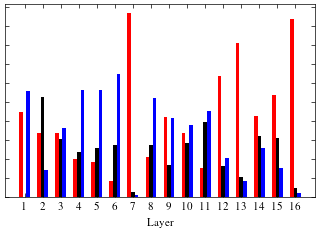

In [4]:
sym = np.load("resnet_sym_vals.npy")
mixed = np.load("resnet_mixed_vals.npy")
anti = np.load("resnet_anti_vals.npy")


x = np.arange(1, len(conv_layers)+1, step=1)
width = 0.2


plt.rcParams['figure.figsize'] = (4, 2.5)

plt.bar(x-0.2, sym, width , color='r') 
plt.bar(x, mixed, width, color='k') 
plt.bar(x+0.2, anti, width, color='b') 

#plt.xticks(x, [']) 
plt.xlabel("Layer") 
#plt.ylabel("\%") 
plt.xticks(x)
plt.yticks(np.arange(0, 1.1, step=0.1), ['']*11)
#plt.title('Resnet50')

plt.minorticks_off()
#plt.legend([r"$\beta\leq0.25$",  r"$0.25<\beta<0.75$", r"$\beta\geq0.75$",] )
plt.savefig('figures/resnet_kernel_type.pdf', dpi=600)

plt.show() 